#The Protein Network Graph to Find Bounding Aminoacids using Variational Quantum Circuits.

# Variational Quantum Circuits in a Protein Network Graph.

# Objetives

* To find bounding amino acids function on a delimited network graph approach that characterized a chemical structure using a variational quantum circuit.
* To apply quantum circuits used in graph theory and optimization problems to map 3D-protein structure into chemical interaction network.
* Using the QAOA variational form to find an approximate solution for the protein folding quadratic program.
* To encourage people to push into quantum computing and solve real molecular biology problems faster than classical methods.



## Introduction. Protein Interactions

The main idea of the proposal es to mapp biochemical interactions inside a 3D-protein structure into a graph network. Therefore each edge will correspond to one of the following chemical interactions of the structure:

*   Hydrophobic 
*   Disulfide (bridnge) 
*   Hydrogen bonds
*   Ionic and aromatic (partial)
*   Cation-$\pi$ 
*   Peptide bond

On the other hand, nodes will correspond to each amino acid in the .pdb protein file. This file is preprocessed previously (order and prepare the data to be read). We extract the main graph from the PDB (protein database) file and delimit it with a few nodes; after this, we will implement a variational quantum circuit to find the function that maximizes the chemical bounding aminoacids representation.



## Optimization Problem




In this case, we use a small example (3nir, Crystal structure of small protein crambin at 0.48 A resolution), with 46 amino acids (nodes) within just one chain (A).


In [ ]:
!pip install qiskit
!pip install biopandas
!pip install proteingraph 
!pip install qiskit-optimization

In [ ]:
import qiskit
qiskit.__version__

'0.18.3'

Importing the libraries needed

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import plotly.graph_objects as go
import matplotlib as mpl
import pandas as pd
from typing import List
from biopandas.pdb import PandasPdb
from proteingraph import read_pdb

from qiskit import BasicAer
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
# from qiskit.aqua.algorithms import VQE
# from qiskit.aqua import aqua_globals
from qiskit.circuit import Parameter, ParameterVector
from qiskit.algorithms.optimizers import SPSA ,COBYLA, SLSQP, ADAM

from qiskit.optimization.applications.ising import tsp
# from qiskit.optimization import QuadraticProgram
from qiskit.aqua import QuantumInstance


from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# from qc_grader.graph_util import display_maxcut_widget, QAOA_widget, graphs

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
import qiskit as qk
# Loading your IBM Quantum account(s)
qk.IBMQ.save_account() #Replace the text my_token for your own token
provider = IBMQ.load_account()

/usr/local/lib/python3.7/dist-packages/qiskit/aqua/__init__.py:86: DeprecationWarning:

The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>

/usr/local/lib/python3.7/dist-packages/qiskit/optimization/__init__.py:92: DeprecationWarning:

The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>

configrc.store_credentials:WARNING:2021-10-28 01:08:00,103: Credentials already present. Set overwrite=True to overwrite.


W can use proteingraph methods to map the protein pdb file into a network interactios (using inside bopandas data structure), once we load the file.

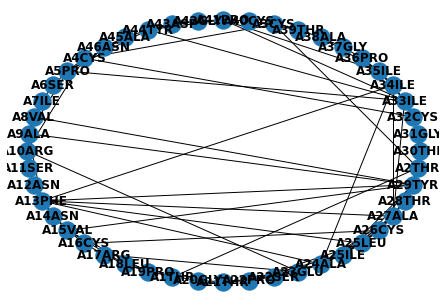

<Figure size 864x864 with 0 Axes>

In [ ]:
p = read_pdb('3nirA.pdb')
nx.draw_shell(p, with_labels=True, font_weight='bold')
plt.figure(figsize=(12,12))
plt.show()

Some criteria (specially a function) will be use to cluster the interactions between the amino amino acids, in this case e condense the graph with weights that represent the kind and number of interactions.

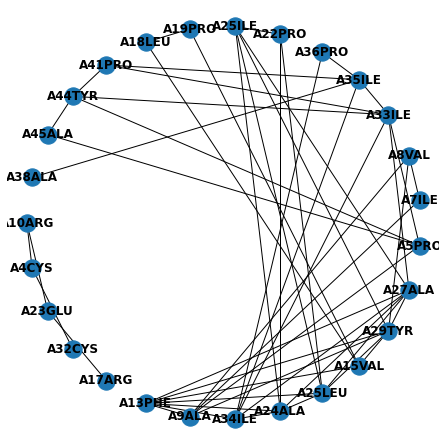

In [ ]:
F= nx.Graph()
back='backbone'
for (x,y,z) in p.edges(data=True):
 l=len(z["kind"])
 if (l >= 2):
  F.add_node(x)
  F.add_node(y)
  F.add_edge(x, y,  kind=z["kind"])
 # if
 else:
  if(not back in z["kind"]):
   F.add_node(x)
   F.add_node(y)
   F.add_edge(x, y, kind=z["kind"])

G= nx.Graph()
for u,c in F.nodes(data=True):
  ss=F.edges(u,data=True)
  s=len(ss)
  if(s>1):
   G.add_node(u)
   for (xx,yy,zz) in ss:
    G.add_node(yy)
    G.add_edge(u, yy, kind= zz["kind"])

plt.figure(figsize=(6,6))
nx.draw_shell(G, with_labels=True, font_weight='bold',
edgelist = G.edges(data=True))
plt.show()



Then, we can continue to reduce the isolate mini-graph and the chemical bondings.

In [ ]:
H = G.copy()
H.remove_node('A38ALA')
H.remove_node('A10ARG')
H.remove_node('A4CYS')
H.remove_node('A23GLU')
H.remove_node('A32CYS')
H.remove_node('A17ARG')


#Por ahora funcion arbitraria
T= H.copy()
T.remove_node('A18LEU')
T.remove_node('A19PRO')
T.remove_node('A8VAL')
T.remove_node('A7ILE')
T.remove_node('A45ALA')
T.remove_node('A44TYR')
T.remove_node('A36PRO')
T.remove_node('A35ILE')
#T=nx.Graph()
T.add_node('45ALAu44TYR',pos=0)
T.add_node('8VALu7ILE',pos=1)
T.add_node('36PROu35ILE',pos=2)
T.add_node('18LEUu19PRO',pos=3)

T.add_edge('45ALAu44TYR','A41PRO' , weight=3, kind=[{'backbone', 'hydrophobic'},{'hydrophobic','hydrophobic'}])
T.add_edge('45ALAu44TYR','A5PRO' , weight=3, kind=[{'backbone', 'hydrophobic'},{'hydrophobic','hydrophobic'}])
T.add_edge('45ALAu44TYR','A33ILE' , weight=3, kind=[{'backbone', 'hydrophobic'},{'hydrophobic'}])
#T.add_edge('41PRO','33ILE' , weight=1, kind=[{'hydrophobic'}])
T.add_edge('8VALu7ILE','A9ALA' , weight=5, kind=[{'backbone', 'hydrophobic'},{'backbone', 'hydrophobic','hydrophobic'}])
T.add_edge('8VALu7ILE','A29TYR' , weight=1, kind=[{'backbone', 'hydrophobic'},{'hydrophobic'}])
T.add_edge('36PROu35ILE','A34ILE' , weight=1, kind=[{'backbone', 'hydrophobic'},{'backbone','hydrophobic','hydrophobic'}])
T.add_edge('36PROu35ILE','A41PRO' , weight=1, kind=[{'backbone', 'hydrophobic'},{'hydrophobic'}])
T.add_edge('36PROu35ILE','A33ILE' , weight=1, kind=[{'backbone', 'hydrophobic'},{'hydrophobic'}])
T.add_edge('18LEUu19PRO','A15VAL' , weight=1, kind=[{'hydrophobic'}, {'backbone','hydrophobic','hydrophobic'}])


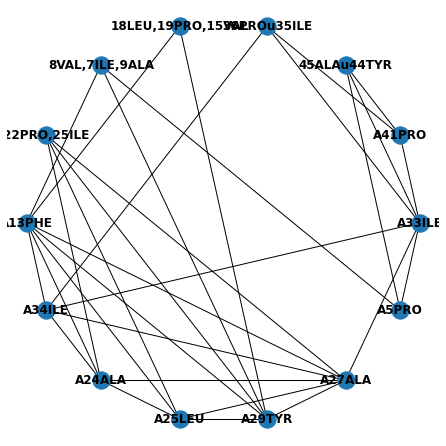

In [ ]:
X= T.copy()
X.remove_node('18LEUu19PRO')
X.remove_node('A15VAL')
X.remove_node('8VALu7ILE')
X.remove_node('A9ALA')
X.remove_node('A22PRO')
X.remove_node('A25ILE')

X.add_node('18LEU,19PRO,15VAL',pos=0)
X.add_node('8VAL,7ILE,9ALA',pos=1)
X.add_node('22PRO,25ILE',pos=2)

X.add_edge('18LEU,19PRO,15VAL','A13PHE', weight=3+3, kind=[{'hydrophobic','backbone','hydrophobic','hydrophobic'},{'hydrophobic'}])
X.add_edge('18LEU,19PRO,15VAL','A29TYR', weight=3+3, kind=[{'hydrophobic','backbone','hydrophobic','hydrophobic'},{'hydrophobic'}])
#'backbone', 'hydrophobic','backbone', 'hydrophobic','hydrophobic'
X.add_edge('8VAL,7ILE,9ALA','A29TYR', weight=3+3, kind=[{'backbone', 'hydrophobic','backbone', 'hydrophobic','hydrophobic'},{'hydrophobic','hydrophobic'}])
X.add_edge('8VAL,7ILE,9ALA','A5PRO', weight=3+3, kind=[{'backbone', 'hydrophobic','backbone', 'hydrophobic','hydrophobic'},{'hydrophobic'}])
X.add_edge('8VAL,7ILE,9ALA','A13PHE', weight=3+3, kind=[{'backbone', 'hydrophobic','backbone', 'hydrophobic','hydrophobic'},{'hydrophobic'}])
#X.add_edge('8VAL,7ILE,29TYR','18LEU,19PRO,15VAL', weight=3+3, kind=[{'backbone', 'hydrophobic'},{'hydrophobic','hydrophobic'}])
X.add_edge('22PRO,25ILE','A25LEU', weight=3+3, kind=[{'hydrophobic'},{'hydrophobic','hydrophobic'}])
X.add_edge('22PRO,25ILE','A27ALA', weight=3+3, kind=[{'hydrophobic'},{'hydrophobic'}])
X.add_edge('22PRO,25ILE','A24ALA', weight=3+3, kind=[{'hydrophobic'},{'hydrophobic','backbone','hydrophobic'}])
X.add_edge('22PRO,25ILE','A29TYR', weight=3+3, kind=[{'hydrophobic'},{'hydrophobic'}])


plt.figure(figsize=(6,6))
  #pos = nx.shell_layout(G)
pos=nx.spring_layout(X)
edge_labels = nx.get_edge_attributes(X, 'weight')
nx.draw_shell(X, with_labels=True, font_weight='bold',
edgelist = X.edges(data=True))
#nx.draw_networkx_edge_labels(T, pos=pos, edge_labels=edge_labels)

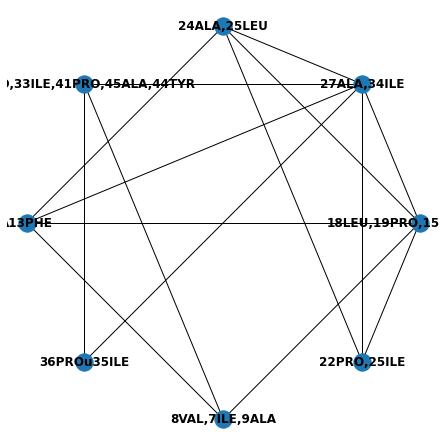

In [ ]:
J= X.copy()
J.remove_node('18LEU,19PRO,15VAL')
J.remove_node('A29TYR')
J.remove_node('A5PRO')
J.remove_node('A33ILE')

J.add_node('18LEU,19PRO,15VAL,29TYR',pos=0)
J.add_node('5PRO,33ILE',pos=1)

J.add_edge('18LEU,19PRO,15VAL,29TYR', 'A13PHE',weight=3+3+2, kind=[{'hydrophobic','backbone','hydrophobic','hydrophobic','hydrophobic'},{'hydrophobic','hydrophobic'}])
J.add_edge('18LEU,19PRO,15VAL,29TYR', '8VAL,7ILE,9ALA',weight=3+3+9, kind=[{'hydrophobic','backbone','hydrophobic','hydrophobic','hydrophobic','backbone', 'hydrophobic','backbone',
 'hydrophobic','hydrophobic'},{'hydrophobic','hydrophobic'}])
J.add_edge('18LEU,19PRO,15VAL,29TYR', 'A25LEU',weight=3+3+2, kind=[{'hydrophobic','backbone','hydrophobic','hydrophobic','hydrophobic'},{'hydrophobic'}])
J.add_edge('18LEU,19PRO,15VAL,29TYR', 'A27ALA',weight=3+3+2, kind=[{'hydrophobic','backbone','hydrophobic','hydrophobic','hydrophobic'},{'hydrophobic'}])
J.add_edge('18LEU,19PRO,15VAL,29TYR', '22PRO,25ILE',weight=3+3+2, kind=[{'hydrophobic',
'backbone','hydrophobic','hydrophobic','hydrophobic','hydrophobic'},{'hydrophobic'}])

J.add_edge('5PRO,33ILE', '8VAL,7ILE,9ALA',weight=3+3+2, kind=[{'hydrophobic','backbone', 'hydrophobic','backbone', 'hydrophobic','hydrophobic'},{'hydrophobic'}])
J.add_edge('5PRO,33ILE', '45ALAu44TYR',weight=3+3+2, kind=[{'hydrophobic','backbone', 'hydrophobic'},{'hydrophobic','hydrophobic','hydrophobic'}])
J.add_edge('5PRO,33ILE', 'A27ALA',weight=3+3+2, kind=[{'hydrophobic'},{'hydrophobic'}])
J.add_edge('5PRO,33ILE', 'A34ILE',weight=3+3+2, kind=[{'hydrophobic'},{'hydrophobic', 'backbone'}])
J.add_edge('5PRO,33ILE', '36PROu35ILE',weight=3+3+2, kind=[{'hydrophobic','backbone', 'hydrophobic'},{'hydrophobic'}])


Y= J.copy()
Y.remove_node('A41PRO')
Y.remove_node('45ALAu44TYR')
Y.remove_node('A27ALA')
Y.remove_node('A34ILE')

Y.add_node('41PRO,45ALA,44TYR',pos=0)
Y.add_node('27ALA,34ILE',pos=1)

Y.add_edge('41PRO,45ALA,44TYR', '36PROu35ILE',weight=3+9+2, kind=[{'backbone', 'hydrophobic','hydrophobic','hydrophobic','backbone','hydrophobic'},{'hydrophobic'}])
Y.add_edge('41PRO,45ALA,44TYR', '5PRO,33ILE',weight=3+9+2+7, kind=[{'backbone', 'hydrophobic','hydrophobic','hydrophobic','hydrophobic'},{'hydrophobic','hydrophobic','hydrophobic'}])
Y.add_edge('27ALA,34ILE', 'A24ALA',weight=1+1+1, kind=[{'hydrophobic'},{'hydrophobic','hydrophobic'}])
Y.add_edge('27ALA,34ILE', 'A25LEU',weight=1+1, kind=[{'hydrophobic'},{'hydrophobic'}])
Y.add_edge('27ALA,34ILE', 'A13PHE',weight=1+1+1, kind=[{'hydrophobic'},{'hydrophobic',
'hydrophobic'}])
Y.add_edge('27ALA,34ILE', '5PRO,33ILE',weight=1+1+1+1+2, kind=[{'hydrophobic',
'hydrophobic'},{'hydrophobic','hydrophobic', 'backbone'}])
Y.add_edge('27ALA,34ILE', '18LEU,19PRO,15VAL,29TYR',
weight=1+1+2+1+1+1+1, kind=[{'hydrophobic','hydrophobic',
'backbone','hydrophobic','hydrophobic','hydrophobic'},{'hydrophobic'}])
Y.add_edge('27ALA,34ILE', '22PRO,25ILE',weight=1+1+1, kind=[{'hydrophobic',
'hydrophobic'},{'hydrophobic'}])
Y.add_edge('27ALA,34ILE', '36PROu35ILE',weight=1+2+1+2+1+1, kind=[{'hydrophobic',
'backbone', 'hydrophobic'},{'backbone','hydrophobic','hydrophobic'}])

N= Y.copy()
N.remove_node('A24ALA')
N.remove_node('A25LEU')
N.remove_node('5PRO,33ILE')
N.remove_node('41PRO,45ALA,44TYR')

N.add_node('24ALA,25LEU',pos=0)
N.add_node('5PRO,33ILE,41PRO,45ALA,44TYR',pos=1)

N.add_edge('24ALA,25LEU', '22PRO,25ILE',weight=1+2+1+1+1+1+2+1, kind=[{'hydrophobic',
'backbone','hydrophobic'},{'hydrophobic','hydrophobic','hydrophobic',
'backbone','hydrophobic'}])
N.add_edge('24ALA,25LEU', '18LEU,19PRO,15VAL,29TYR', weight=1+2+1+2+1+1+1+1, kind=[{'hydrophobic',
'backbone','hydrophobic','backbone','hydrophobic','hydrophobic',
'hydrophobic'},{'hydrophobic'}])
N.add_edge('24ALA,25LEU', '27ALA,34ILE', weight=1+2+1+1+1+1, kind=[{'hydrophobic',
'backbone','hydrophobic'},{'hydrophobic','hydrophobic','hydrophobic'}])
N.add_edge('24ALA,25LEU', 'A13PHE', weight=1+2+1+1, kind=[{'hydrophobic',
'backbone'},{'hydrophobic','hydrophobic'}])

N.add_edge('5PRO,33ILE,41PRO,45ALA,44TYR', '36PROu35ILE', weight=3+9+7+12, kind=[{'backbone', 'hydrophobic','hydrophobic',
'hydrophobic','hydrophobic','hydrophobic','hydrophobic',
'hydrophobic','backbone', 'hydrophobic'},{'hydrophobic','hydrophobic'}])
N.add_edge('5PRO,33ILE,41PRO,45ALA,44TYR', '8VAL,7ILE,9ALA', weight=3+9+7, kind=[{'backbone', 'hydrophobic','hydrophobic',
'hydrophobic','hydrophobic','hydrophobic','hydrophobic','hydrophobic','backbone',
'hydrophobic','backbone', 'hydrophobic','hydrophobic'},{'hydrophobic'}])
N.add_edge('5PRO,33ILE,41PRO,45ALA,44TYR', '27ALA,34ILE', weight=3+9+7, kind=[{'backbone', 'hydrophobic','hydrophobic',
'hydrophobic','hydrophobic','hydrophobic','hydrophobic','hydrophobic',
'hydrophobic'},{'hydrophobic','hydrophobic', 'backbone'}])



plt.figure(figsize=(6,6))
  #pos = nx.shell_layout(G)
pos=nx.spring_layout(N)
edge_labels = nx.get_edge_attributes(N, 'weight')
nx.draw_shell(N, with_labels=True, font_weight='bold',
edgelist = N.edges(data=True))
#nx.draw_networkx_edge_labels(T, pos=pos, edge_labels=edge_labels)
plt.show()

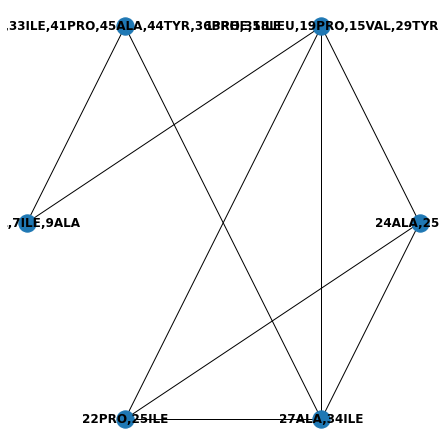

In [ ]:
FI=N.copy()
FI.remove_node('36PROu35ILE')
FI.remove_node('A13PHE')
FI.remove_node('5PRO,33ILE,41PRO,45ALA,44TYR')
FI.remove_node('18LEU,19PRO,15VAL,29TYR')

FI.add_node('13PHE,18LEU,19PRO,15VAL,29TYR',pos=0)
FI.add_node('5PRO,33ILE,41PRO,45ALA,44TYR,36PRO,35ILE',pos=1)

FI.add_edge('5PRO,33ILE,41PRO,45ALA,44TYR,36PRO,35ILE', '27ALA,34ILE',
weight=2+1+1+1+1+1+1+1+2+1+1+1+1+1+1+2+2+1+1, kind=[{'backbone', 'hydrophobic','hydrophobic',
'hydrophobic','hydrophobic','hydrophobic','hydrophobic',
'hydrophobic','backbone', 'hydrophobic','hydrophobic','hydrophobic',
'hydrophobic'},{'hydrophobic','hydrophobic', 'backbone','backbone','hydrophobic','hydrophobic'}])
FI.add_edge('5PRO,33ILE,41PRO,45ALA,44TYR,36PRO,35ILE', '8VAL,7ILE,9ALA',
weight=2+1+1+1+1+1+1+1+2+1+1+1+2+1+2+1+1+1, kind=[{'backbone', 'hydrophobic','hydrophobic',
'hydrophobic','hydrophobic','hydrophobic','hydrophobic',
'hydrophobic','backbone', 'hydrophobic','hydrophobic',
'hydrophobic','backbone', 'hydrophobic','backbone', 'hydrophobic',
'hydrophobic'},{'hydrophobic'}])

FI.add_edge('13PHE,18LEU,19PRO,15VAL,29TYR', '8VAL,7ILE,9ALA', weight=2+1+2+1+1+1+2+1+1+1+1+1+1+1+1,
kind=[{'backbone', 'hydrophobic','backbone', 'hydrophobic','hydrophobic','hydrophobic',
'backbone','hydrophobic','hydrophobic','hydrophobic','hydrophobic',
'hydrophobic'},{'hydrophobic','hydrophobic','hydrophobic'}])
FI.add_edge('13PHE,18LEU,19PRO,15VAL,29TYR', '27ALA,34ILE', weight=1+2+1+1+1+1+1+1+1+1+1,
kind=[{'hydrophobic','backbone','hydrophobic','hydrophobic','hydrophobic',
'hydrophobic','hydrophobic','hydrophobic'},{'hydrophobic','hydrophobic','hydrophobic'}])
FI.add_edge('13PHE,18LEU,19PRO,15VAL,29TYR', '24ALA,25LEU', weight=1+2+1+1+1+1+1+1+2+1+1+1+1,
kind=[{'hydrophobic','backbone','hydrophobic','hydrophobic','hydrophobic',
'hydrophobic','hydrophobic','hydrophobic','backbone'},{'hydrophobic','hydrophobic','hydrophobic','hydrophobic'}])
FI.add_edge('13PHE,18LEU,19PRO,15VAL,29TYR', '22PRO,25ILE', weight=1+2+1+1+1+1+1+1+1,
 kind=[{'hydrophobic','backbone','hydrophobic','hydrophobic','hydrophobic',
 'hydrophobic','hydrophobic','hydrophobic'},{'hydrophobic'}])

plt.figure(figsize=(6,6))
  #pos = nx.shell_layout(G)
pos=nx.spring_layout(FI)
edge_labels = nx.get_edge_attributes(FI, 'weight')
nx.draw_shell(FI, with_labels=True, font_weight='bold',
edgelist = FI.edges(data=True))
#nx.draw_networkx_edge_labels(T, pos=pos, edge_labels=edge_labels)
plt.show()

Finally, we can reduce the graph with enough number of nodes that  can be processed by the qunatum circuit(limited by the number of qubits available).

# Representation of the protein folding in a weight graph

The final six-node graph represents the clusterized biochemical-interaction network, where each node depicts an amino acid group within the whole protein structure. Each edge weight summarizes the assessment of the chemical interaction function between these groups od amino acids (nodes).

In [ ]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


distance
 [[ 0 23 22  0  0  0]
 [23  0  0 12  7  3]
 [22  0  0 18  0  0]
 [ 0 12 18  0 15 10]
 [ 0  7  0 15  0 10]
 [ 0  3  0 10 10  0]]


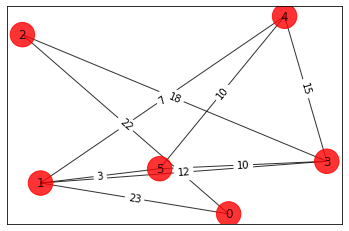

In [ ]:
# Its is used because the coordinates of each node (ins.coord) in order to draw the graph
n = 6
num_qubits = n ** 2
ins = tsp.random_tsp(n, seed=123)

G = nx.Graph()
G.add_nodes_from(np.arange(0,6,1))

# We assign numerical values ​​to each protein fold to represent the nodes.

# '5PRO,33ILE,41PRO,45ALA,44TYR,36PRO,35ILE' = 0
# '27ALA,34ILE' = 1
# '8VAL,7ILE,9ALA' = 2
# '13PHE,18LEU,19PRO,15VAL,29TYR' = 3
# '24ALA,25LEU' = 4
# '22PRO,25ILE'= 5

edges_with_weight =[
                    (0, 1,23),
                    (0, 2,22),
                    (3, 2,18),
                    (3, 1,12),
                    (3, 4,15),
                    (3, 5,10),
                    (1,4,7),
                    (1,5,3),
                    (4,5,10)]
# edges_with_weight = [(0,1,2.0),(0,2,3.0),(0,3,2.0),(0,4,4.0),(0,5,1.0),(1,2,4.0),(1,3,1.0),(1,4,1.0),(1,5,3.0),(2,4,2.0),(2,5,3.0),(3,4,5.0),(3,5,1.0)]
G.add_weighted_edges_from(edges_with_weight)
# G.add_nodes_from(np.arange(0, ins.dim, 1))
colors = ['r' for node in G.nodes()]

weight_matrix = nx.adjacency_matrix(G).toarray()
size = weight_matrix.shape[0]
print('distance\n', weight_matrix)

pos = {k: v for k, v in enumerate(ins.coord)}
draw_graph(G, colors, pos)

# Brute force approach

order = (0, 1, 2, 3, 4, 5) Weight of protein folding = 66
order = (0, 1, 3, 4, 5, 2) Weight of protein folding = 82
order = (0, 1, 4, 5, 3, 2) Weight of protein folding = 90
order = (0, 1, 5, 4, 3, 2) Weight of protein folding = 91
Best order from brute force = (0, 1, 5, 4, 3, 2) with total weight = 91


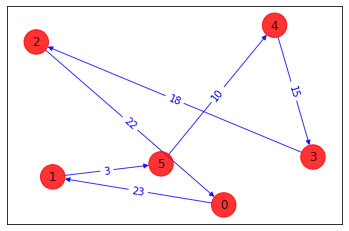

In [ ]:
from itertools import permutations

def brute_force_pf(w, N):
    """Solves the best weight proteing folding path from weight and Nodes in the graph.
    Args:
        w: Weight matrix from the Graph.
        N: Number of nodes from the Graph.
    Returns:
        last_best_distance, Weight of totqal protein folding
    """
    a=list(permutations(range(1,N)))
    last_best_distance = 0
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j,pre_j]
            pre_j = j
        distance = distance + w[pre_j,0]
        order = (0,) + i
        if distance > last_best_distance:
            best_order = order
            last_best_distance = distance
            print('order = ' + str(order) + ' Weight of protein folding = ' + str(distance))
    return last_best_distance, best_order

best_distance, best_order = brute_force_pf(weight_matrix, size)
print('Best order from brute force = ' + str(best_order) + ' with total weight = ' + str(best_distance))

def draw_pf_solution(G, order, colors, pos):
  """Draw the best weight proteing folding path from weight and Nodes in the graph.
    Args:
        G: Graph.
        order: best_order (path).
        colors: edge_color.
        pos : cordinates of each node from th graph.
    Returns:
        last_best_distance, Weight of totqal protein folding
    """
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)

draw_pf_solution(G, best_order, colors, pos)

# Protein interaction problem to QUBO (Quadratic Unconstrained Binary Optimization)

Base on the travelling sales man, we implement the cost function in order to solve the problem of found the most interacting amino acids withing a protein structure in functon of the weights of the final clustered graph, in this case we adequate the problem to maximize the cost function and get the best weight distance (function of protein structure).
 
\begin{equation}
C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}+ A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2,
\end{equation}

Protein folding as a Quadratic Program

We can reformulate it in the standard form for quadratic programs as written below.
$$
\begin{align}
\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1} + A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2 &= \sum_{i,j}\sum_{p} x_{i,p} w_{ij} x_{j,p+1} + A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2  \\
&= A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2 + \sum_{i,j}\sum_{p} x_{i,p} w_{ij} x_{j,p+1} \\
&= c^T x + x^T Q x, \\
\end{align}
$$
for $Q$ and $c$ defined as follows
$$
Q_{ij} = W_{ij} \qquad c_i = \sum_{i=1}^n i.
$$

<font color='red'>

At the moment we still working to solve the  $c_i$ from the cost function equation.
</font>

We obtain an optimization instance with binary variables, a quadratic objective function and without any variable constraints. A quadratic program of that form is also called a quadratic unconstrained binary optimization instance, or QUBO for short.

In [ ]:
quadratic_program = QuadraticProgram('protein folding')
print(quadratic_program.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: protein folding

Minimize
 obj:
Subject To

Bounds
End



In [ ]:
def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    """Constructs a quadratic program from a given graph for a proteing folding problem instance.
    Args:
        graph: Underlying graph of the problem.
    Returns:
        QuadraticProgram
    """
    #Get weight matrix of graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    #Build qubo matrix Q from weight matrix W
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    # A is the maximun value in the weight_matrix
    # A = (max(max(weight_matrix)))
    for i in range(size):
        for j in range(size):
            qubo_matrix[i, j] += weight_matrix[i, j]
    #We are working in this part of the equation        
    for i in range(size):
        for j in range(size):
            qubo_vector[i] += i
            # qubo_vector[i] = A * (1-(i*j))**2 + A * (1-(j*i))**2

    #Code
    for i in range (size):
        quadratic_program.binary_var(name = 'x_'+str(i))
        
    quadratic_program.maximize(quadratic = qubo_matrix, linear = qubo_vector)

    return quadratic_program

In [ ]:
quadratic_program = quadratic_program_from_graph(G)
print(quadratic_program.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: protein folding

Maximize
 obj: 6 x_1 + 12 x_2 + 18 x_3 + 24 x_4 + 30 x_5 + [ 92 x_0*x_1 + 88 x_0*x_2
      + 48 x_1*x_3 + 28 x_1*x_4 + 12 x_1*x_5 + 72 x_2*x_3 + 60 x_3*x_4
      + 40 x_3*x_5 + 40 x_4*x_5 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



In [ ]:
quadratic_program = QuadraticProgram('proteing folding')
print(quadratic_program.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: proteing folding

Minimize
 obj:
Subject To

Bounds
End



# The QAOA varational form and MinimumEigenOptimizer

In [ ]:
backend = Aer.get_backend('statevector_simulator')
qaoa = QAOA(optimizer = ADAM(), quantum_instance = backend, reps=1, initial_point = [0.1,0.1])
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
quadratic_program = quadratic_program_from_graph(G)
result = eigen_optimizer.solve(quadratic_program)
print(result)

optimal function value: 330.0
optimal value: [1. 1. 1. 1. 1. 1.]
status: SUCCESS


In [ ]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(quadratic_program)
print(result)

optimal function value: 330.0
optimal value: [1. 1. 1. 1. 1. 1.]
status: SUCCESS
